# Analysis of fragmented malware detection by Suricata

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import glob

import re
from collections import defaultdict
import seaborn
import orjson

In [2]:
category = '_unfragmented'

In [3]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

In [4]:
def get_json_data(file):
    return [orjson.loads(line) for line in open(file, "rb")]

In [5]:
def get_alerts_and_packets(json_data):
    alerts = [line for line in json_data if "alert" in line]
    packets = len(json_data)
    return alerts, packets

In [6]:
def get_signatures(alerts):
    nmbr_signatures = defaultdict(int)
    severity = defaultdict(int)
    packets = 0
    for entry in alerts:
        nmbr_signatures[entry['alert']['signature']] += 1
        severity[entry['alert']['signature']] = entry['alert']['severity']
    return nmbr_signatures, severity

In [7]:
total_packets = []
total_signatures = []
total_severity = []

severity_dict = defaultdict(int)
for filepath in sorted(glob.glob('theZoo' + category + '/**/*.json')):
    json_data = get_json_data(filepath)
    alerts, packets = get_alerts_and_packets(json_data)
    nmbr_signatures, severity = get_signatures(alerts)
    
    for key, value in severity.items():
        severity_dict[key] = value
    total_packets.append(packets)
    total_signatures.append(nmbr_signatures)
    total_severity.append(severity)


In [8]:
def make_xlabels(data):
    x_ticks = [i for i in data.keys()]
    xlabels_new = [re.sub("(.{5})", "\\1\n", label, 0, re.DOTALL) for label in x_ticks]
    return xlabels_new

In [9]:
def plot_alerts(nmbr_signatures, file, save=None):    
    xlabels_new = make_xlabels(nmbr_signatures)
    fig, ax = plt.subplots()
    file = file.removesuffix('/eve.json')
    file = file.removeprefix('suricata_logs/')
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='white', linestyle='solid')
    ax.xaxis.grid(color='white', linestyle='solid')
    ax.set_facecolor("lightgrey")
    ax.set_xticks(np.arange(len(nmbr_signatures)), xlabels_new)
    ax.set_ylabel('Number of alerts')
    ax.set_xlabel('Alert name')
    ax.set_title(f'Number of alerts in file {file}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.set_size_inches(8,4)
    ax.bar(np.arange(len(nmbr_signatures)), nmbr_signatures.values())
    
    if save is not None:
        fig.savefig(save, bbox_inches="tight")

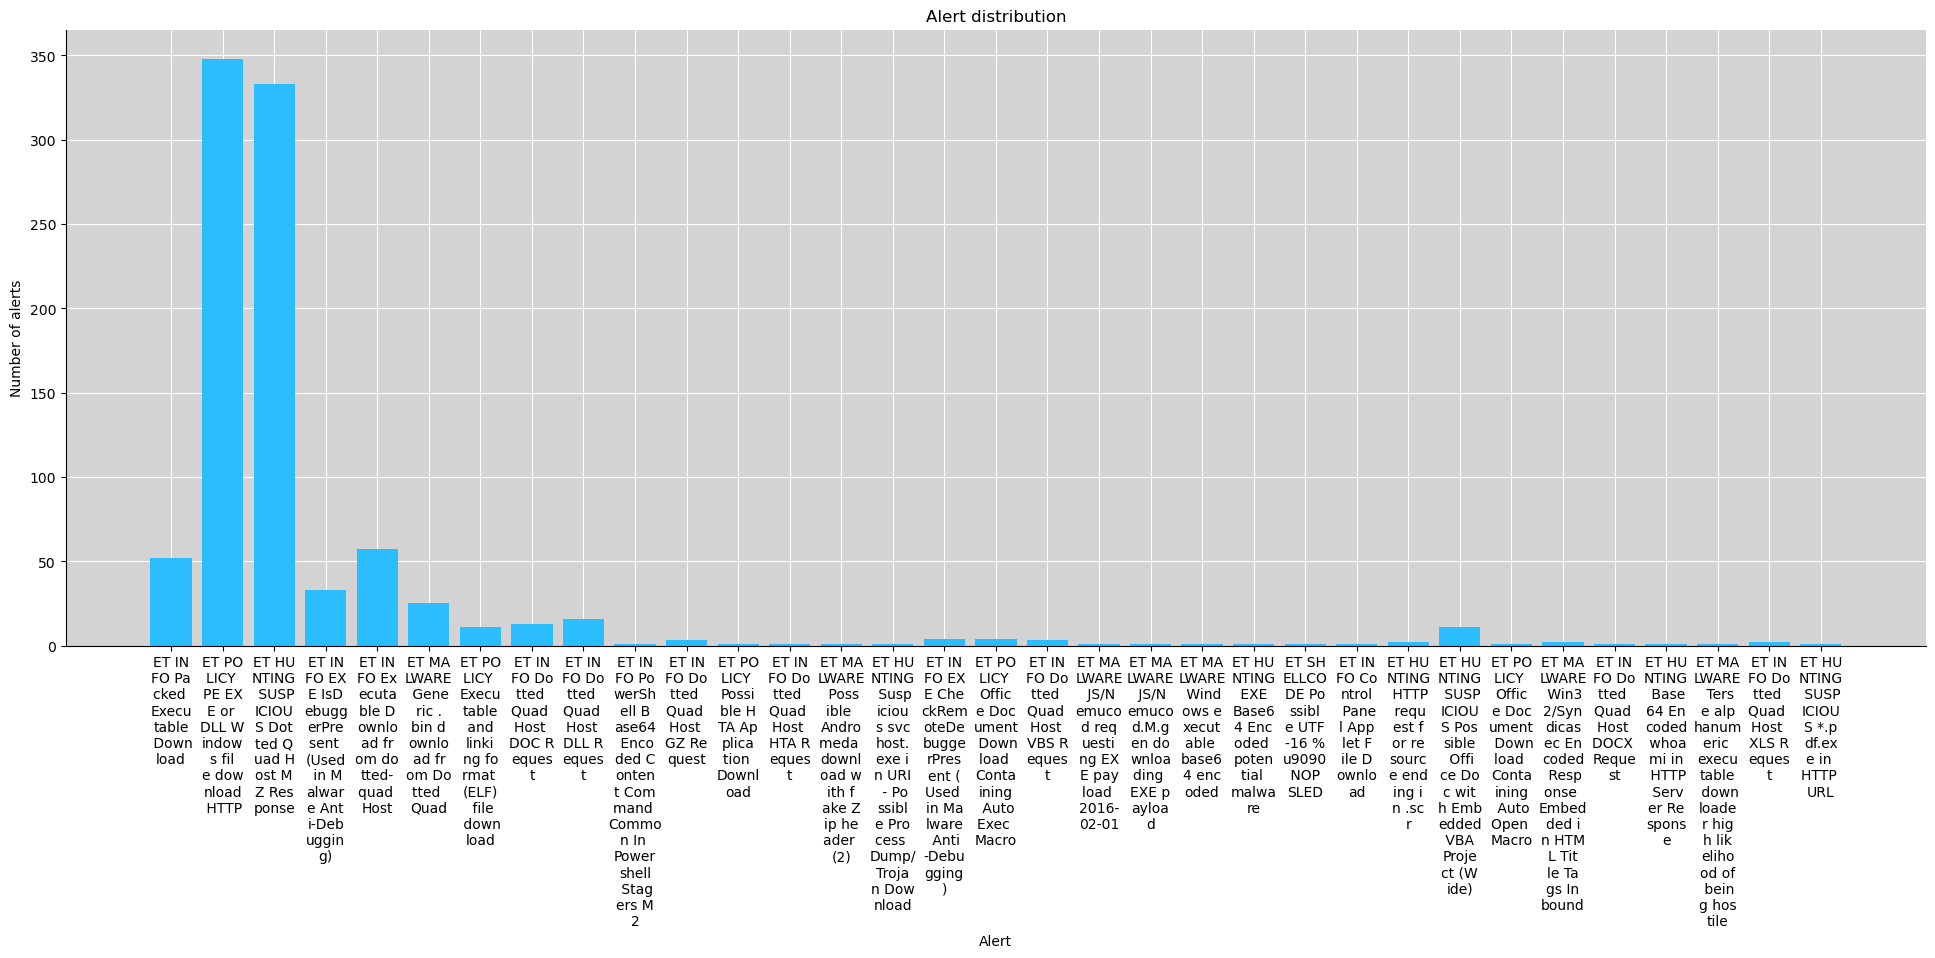

In [10]:
def plot_alert_distribution(dist, severity, save=None):
    # TODO: Add severity to xticks
    total_sigs = defaultdict(int)
    for signatures in dist:
        for key, value in signatures.items():
            total_sigs[key] += value
    xlabels_new = make_xlabels(total_sigs)

    fig, ax = plt.subplots()
    fig.set_size_inches(24,8)
    ax.set_xticks(np.arange(len(total_sigs)), xlabels_new)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='white', linestyle='solid')
    ax.xaxis.grid(color='white', linestyle='solid')
    ax.set_facecolor("lightgrey")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Alert distribution')
    ax.set_xlabel('Alert')
    ax.set_ylabel('Number of alerts')
    ax.bar(np.arange(len(total_sigs)), total_sigs.values())
    
    if save is not None:
        fig.savefig(save, bbox_inches="tight")
        
plot_alert_distribution(total_signatures, severity_dict, save='plots/alert_dist' + category)

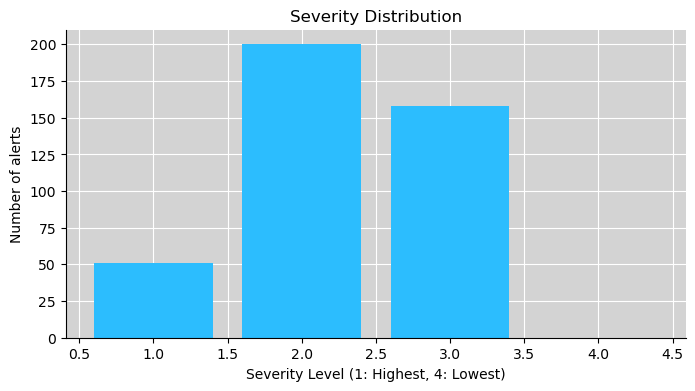

In [11]:
def plot_severity_distribution(dist, save=None):
    # highest severity: 1, lowest severity: 4
    # Theoretically until 255
    severity_range = [1,2,3,4]
    total_sigs = defaultdict(int)
    for signatures in dist:
        for key, value in signatures.items():
            total_sigs[value] += 1

    for key in severity_range:
        if key not in total_sigs.keys():
            total_sigs[key] = 0
    fig, ax = plt.subplots()
    fig.set_size_inches(8,4)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='white', linestyle='solid')
    ax.xaxis.grid(color='white', linestyle='solid')
    ax.set_facecolor("lightgrey")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Severity Distribution')
    ax.set_xlabel('Severity Level (1: Highest, 4: Lowest)')
    ax.set_ylabel('Number of alerts')
    ax.bar(severity_range, total_sigs.values())
    
    if save is not None:
        fig.savefig(save)
        
plot_severity_distribution(total_severity, save='plots/severity_dist' + category)

935
2806


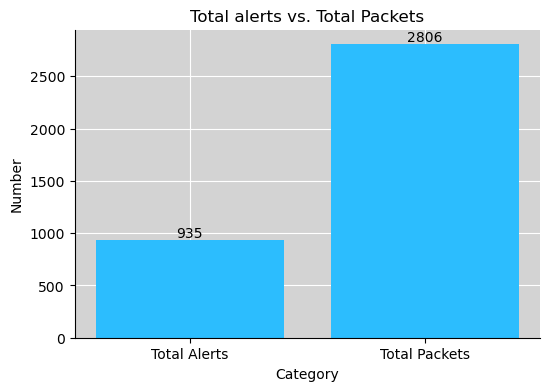

In [12]:
def plot_packet_alerts(packets, total_signatures, save=None):    
    total_sigs = 0
    for elem in total_signatures:
        for value in elem.values():
            total_sigs += value
    
    total_packets = 0
    for elem in packets:
        total_packets += elem
    print(total_sigs)
    print(total_packets)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='white', linestyle='solid')
    ax.xaxis.grid(color='white', linestyle='solid')
    ax.set_facecolor("lightgrey")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Total alerts vs. Total Packets')
    ax.set_xlabel('Category')
    ax.set_ylabel('Number')
    ax.set_xticks(range(2),['Total Alerts', 'Total Packets'])
    bar = ax.bar(np.arange(2), [total_sigs, total_packets])
    ax.bar_label(bar)
    
    if save is not None:
        fig.savefig(save)

plot_packet_alerts(total_packets, total_signatures, save='plots/packet_alerts' + category)

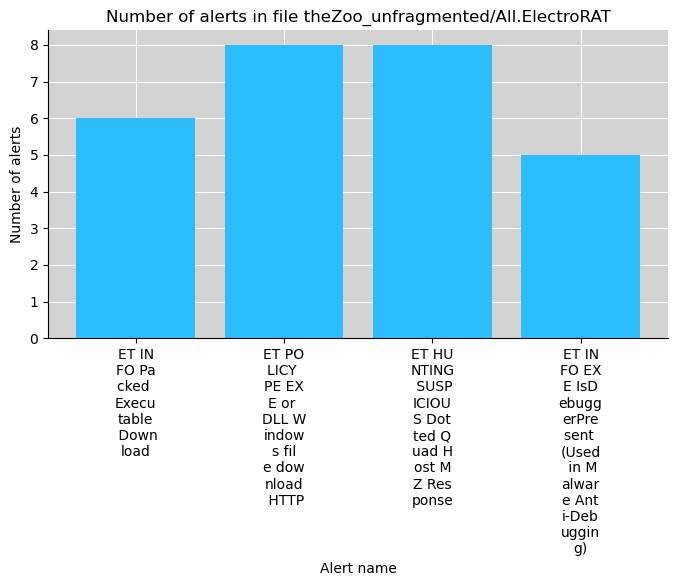

In [13]:
file = 'theZoo' + category + '/All.ElectroRAT/eve.json'
json_data = get_json_data(file)
alerts, packets = get_alerts_and_packets(json_data)
nmbr_signatures, severity = get_signatures(alerts)

plot_alerts(nmbr_signatures, file, save=f'plots/All.ElectroRAT' + category + '.png')